We then performed a few additional steps to prepare the light curves to be used as inputs to our neural network. For each TCE in the training set, we removed points corresponding to transits of any other confirmed planets in the system. Then, we "flattened" the light curve (that is, we removed low-frequency variability) by fitting a basis spline to the light curve and dividing it by the best-fit spline. To preserve transits, we removed the TCE's in-transit points while fitting the spline and linearly interpolated over those transits. We iteratively fit the spline, removed $3\sigma $ outliers, and refit the spline while interpolating over those outliers to prevent the spline from being "pulled" by discrepant points like cosmic-ray hits. This process is illustrated in Figure 3 of Vanderburg & Johnson (2014).

One parameter we had to choose when fitting the spline was the spacing of spline "knots" or "break points," between which the spline calculates its piecewise polynomial coefficients. Each Kepler light curve has different low-frequency stellar variability characteristics, so using one break-point spacing for all light curves is suboptimal. Instead, we chose the optimal spacing of spline break points for each light curve by fitting splines with different break-point spacings, calculating the Bayesian information criterion (BIC; Schwarz 1978) for each spline, and choosing the break-point spacing that minimized the BIC.

In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas
import numpy

dataset = pandas.read_pickle('./kepler_dataset.pkl')
print(dataset)

  131.5121783 131.5326127 131.5530469 131.5734811 131.5939153 131.6143497  \
0    0.000346    0.000323    0.000007    0.000216    0.000168   -0.000377   
1          --          --          --          --          --          --   
2   -0.000403   -0.000068    0.000111    0.000065    0.000168    0.000091   
3          --          --    0.000103   -0.000105    0.000006   -0.000031   
4   -0.001675    0.000907          --          --          --          --   

  131.6347839 131.6552181 131.6756525 131.6960867  ...   kepid_y tce_plnt_num  \
0    0.000691    0.000132   -0.000102   -0.000381  ...  11502172            2   
1          --          --          --          --  ...  10268907            1   
2    0.000157    0.000803   -0.000013   -0.000009  ...   6867766            1   
3   -0.000031    0.000009   -0.000138    0.000012  ...   9958053            4   
4          --          --          --          --  ...   6061584            2   

  tce_period tce_period_err tce_time0bk tce_time0b

need to work with masked data -. which encoded missing values

In [9]:
flux = dataset.iloc[2, 0:71427].to_numpy()
#print(type(flux[0].mask), flux[0].mask, flux.data, numpy.ma.getdata(flux), numpy.ma.getmaskarray(flux))
#masked_a = numpy.ma.array(numpy.ma.getdata(flux), mask=numpy.ma.getmaskarray(flux))
test = numpy.array(numpy.where(numpy.ma.getdata(flux))).flatten()
test_2 = numpy.array(numpy.ma.getdata(flux
print(test)
#print(masked_a)
#print(type(flux[0]))
time = numpy.array(dataset.columns[:-12]).astype('float')
lc = lk.LightCurve(time= time, flux = flux)
lc.scatter()

#print(lc.time.value,len(lc.time), lc.time.format)
#print(lc.flux)

row = dataset.iloc[2,:]
period = row['tce_period']
t0 = row['tce_time0bk']
duration_hours = row['tce_duration']
print(period,t0,duration_hours)

AttributeError: 'numpy.ndarray' object has no attribute 'filled'

clean outliers, we can assume the data is already preprocessed for instrumental noise, the light curves also appear to be normalized and flattened

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

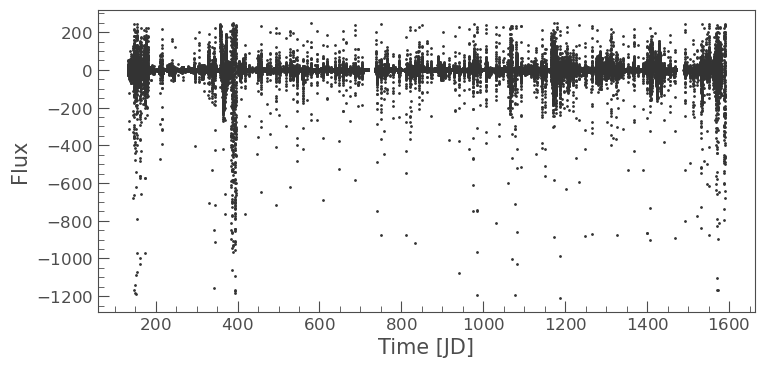

In [3]:
lc_flat = lc.flatten(window_length=901).remove_outliers(sigma=20, sigma_upper=4)
lc_flat.scatter()

Now fold the cleaned, flattened lightcurve:

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

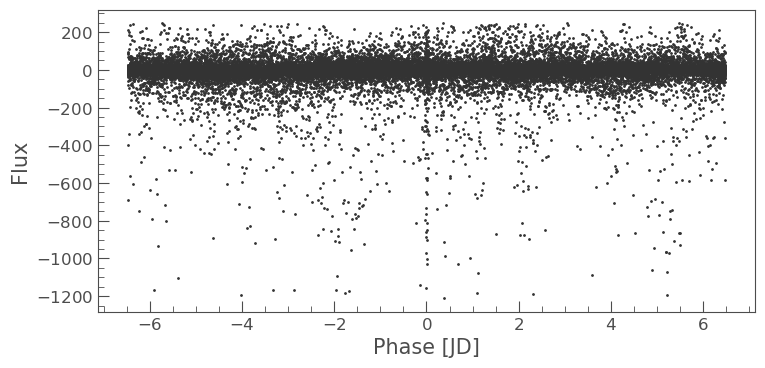

In [4]:
lc_fold = lc_flat.fold(period, epoch_time=t0)
lc_fold.scatter()

Now let’s generate the global input representation by binning:

In [5]:
lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1
print(numpy.nanmin(lc_global.flux))
print(lc_global.flux)
#lc_global = (lc_global / numpy.nanmin(numpy.abs(lc_global.flux)) ) * 2.0 + 1
lc_global = (lc_global / numpy.abs(lc_global.flux.min()) ) * 2.0 + 1
print(lc_global.flux)
lc_global.flux.shape

-40.90779732463199
[-4.8604844  22.35320207 -4.48388964 ... -7.06756275  2.02747458
 40.44769528]
[0.7623688  2.09285777 0.78078069 ... 0.65446378 1.09912411 2.97750541]


/opt/conda/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=-9.11e-01 +/- 1.24e+01); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,
/opt/conda/lib/python3.7/site-packages/lightkurve/lightcurve.py:1058: LightkurveWarning: The light curve has a negative median flux (-9.11e-01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning,


(2593,)

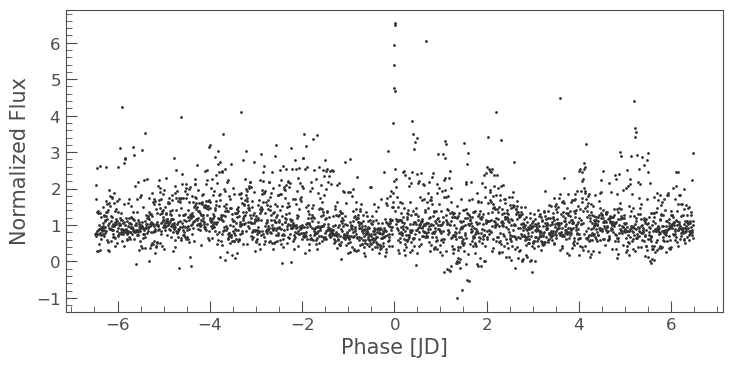

In [6]:
lc_global.scatter();

In [7]:
print(lc_global.flux)

[0.7623688  2.09285777 0.78078069 ... 0.65446378 1.09912411 2.97750541]
